In [1]:
# Investigating which classes suffer from test-time augmentation,
# and why
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
from dataloaders import get_cifar100_dataloader
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from imagenet_classes import imagenet_classes


sns.set_style('white')
n_classes = 100
hf = h5py.File('../cifar100/five_crop_hflip_scale/model_outputs/val/cifar100_cnn.h5', 'r')
outputs = []
labels = []
for key in hf.keys():
    if 'inputs' in key:
        batch_key = key
        label_key = key[:-7] + "_labels"
        outputs.append(hf[batch_key][:])
        labels.append(hf[label_key][:])
outputs = np.concatenate(outputs, axis=1)
labels = np.concatenate(labels)

Using GPU:0


In [2]:
# standard TTA errors
stta_preds = np.mean(outputs, axis=0)
orig_preds = outputs[12,:,:]

In [3]:
stta_correct_idxs = np.where(np.argmax(stta_preds, axis=1) == labels)[0]
stta_incorrect_idxs = np.where(np.argmax(stta_preds, axis=1) != labels)[0]
orig_correct_idxs = np.where(np.argmax(orig_preds, axis=1) == labels)[0]
orig_incorrect_idxs = np.where(np.argmax(orig_preds, axis=1) != labels)[0]

In [4]:
print("Original accuracy: ", len(orig_correct_idxs)/len(orig_preds))
print("Standard test-time augmentation accuracy: ", (len(stta_correct_idxs))/len(orig_preds))

Original accuracy:  0.7426
Standard test-time augmentation accuracy:  0.7535


In [5]:
corruptions = set(stta_incorrect_idxs).intersection(orig_correct_idxs)
corrections = set(stta_correct_idxs).intersection(orig_incorrect_idxs)

In [6]:
len(corruptions), len(corrections)

(255, 364)

In [7]:
corrected_class_map = Counter(labels[list(corrections)])
corrupted_class_map = Counter(labels[list(corruptions)])
net_stta_improvement = {}
for k in corrected_class_map.keys():
    if k in corrupted_class_map:
        net_stta_improvement[k] = corrected_class_map[k] - corrupted_class_map[k]
    else:
        net_stta_improvement[k] = corrected_class_map[k]
for k in corrupted_class_map.keys():
    if k not in net_stta_improvement:
        net_stta_improvement[k] = 0 - corrupted_class_map[k]


In [8]:
stta_order = sorted(net_stta_improvement, key= net_stta_improvement.get)
flowers_classes = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm']

In [9]:
dl = get_cifar100_dataloader(False, 64)
#>=6% decrease in accuracy, up to 10%
harmed_class_names = [flowers_classes[int(i)] for i in stta_order[:15]]
harmed_class_nums = [net_stta_improvement[i] for i in stta_order[:15]]
#>10\% improvement in accuracy (up to 20\%)
helped_class_names = [flowers_classes[int(i)] for i in stta_order[-15:]]
helped_class_nums = [net_stta_improvement[i] for i in stta_order[-15:]]

Files already downloaded and verified


In [10]:
def unnormalize_imnet(img):
    std = [0.229, 0.224, 0.225]
    img = img * np.array(std)
    mean = [0.485, 0.456, 0.406]
    img = img + np.array(mean)
    return img

def unnormalize_flowers(img):
    std = [0.2944, 0.2465, 0.2735]
    img = img * np.array(std)
    mean = [0.5208, 0.4205, 0.3441]
    img = img + np.array(mean)
    return img

def unnormalize_cifar100(img):
    std = [0.5, 0.5, 0.5]
    img = img * np.array(std)
    mean = [0.5, 0.5, 0.5]
    img = img + np.array(mean)
    return img

In [11]:
from tqdm.notebook import tqdm
harmed_class_labels = []
harmed_class_images = []
helped_class_labels = []
helped_class_images = []
for X, y in tqdm(dl):
    for i in range(len(X)):
        if y[i] in stta_order[-15:]:
            helped_class_images.append(X[i])
            helped_class_labels.append(y[i])
        elif y[i] in stta_order[:15]:
            harmed_class_images.append(X[i])
            harmed_class_labels.append(y[i])
helped_class_labels = [l.item() for l in helped_class_labels]
harmed_class_labels = [l.item() for l in harmed_class_labels]
helped_class_images = [i.cpu().numpy() for i in helped_class_images]
harmed_class_images = [i.cpu().numpy() for i in harmed_class_images]

<Figure size 432x288 with 0 Axes>

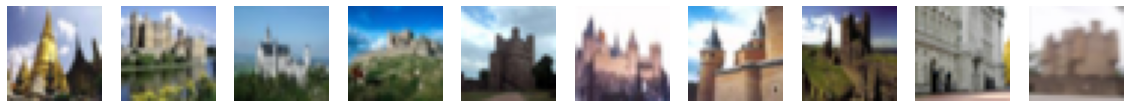

<Figure size 432x288 with 0 Axes>

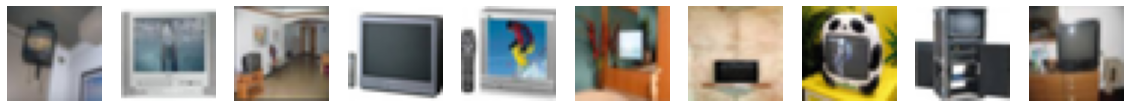

<Figure size 432x288 with 0 Axes>

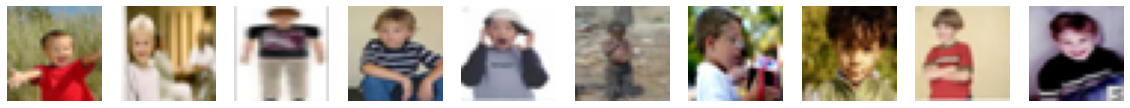

<Figure size 432x288 with 0 Axes>

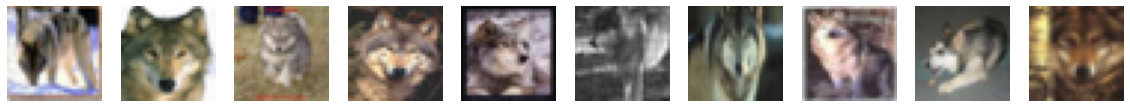

<Figure size 432x288 with 0 Axes>

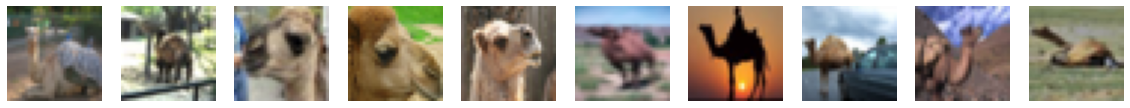

<Figure size 432x288 with 0 Axes>

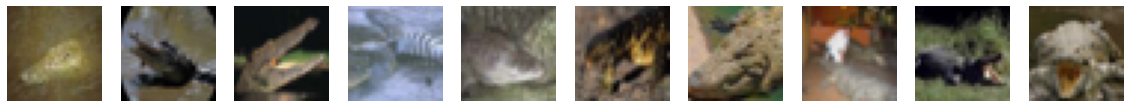

<Figure size 432x288 with 0 Axes>

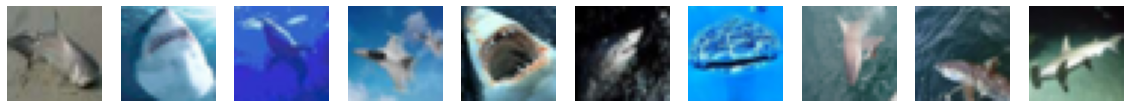

<Figure size 432x288 with 0 Axes>

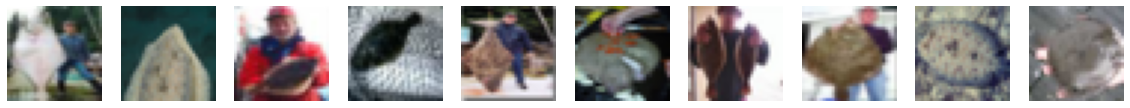

<Figure size 432x288 with 0 Axes>

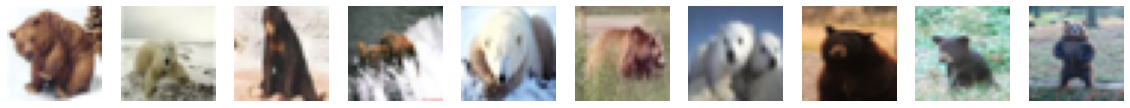

<Figure size 432x288 with 0 Axes>

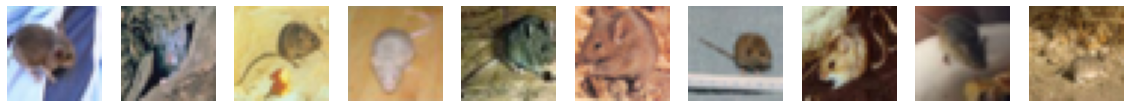

In [12]:
n_images = 10
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 4))
    label = stta_order[-10:][j]
    plot_idxs = np.where(helped_class_labels == label)[0]
    for i in range(n_images):
        ax = axs[i%10]
        img = np.transpose(helped_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_cifar100(img)
        ax.imshow((img*255).astype(np.uint8))
        ax.axis('off')

<Figure size 432x288 with 0 Axes>

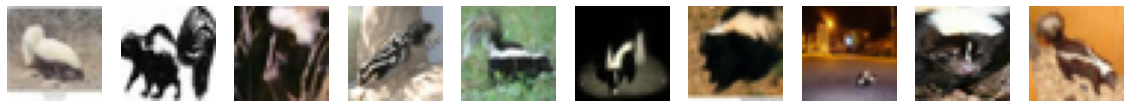

<Figure size 432x288 with 0 Axes>

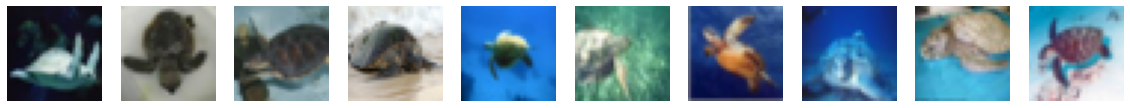

<Figure size 432x288 with 0 Axes>

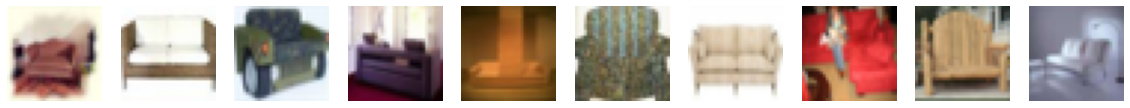

<Figure size 432x288 with 0 Axes>

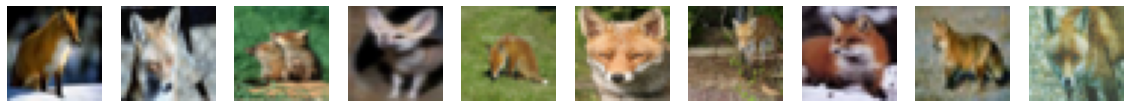

<Figure size 432x288 with 0 Axes>

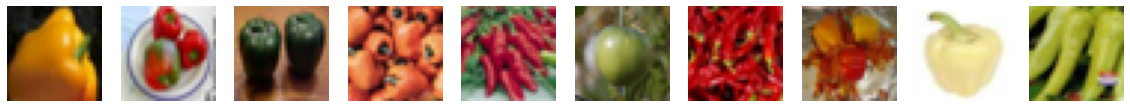

<Figure size 432x288 with 0 Axes>

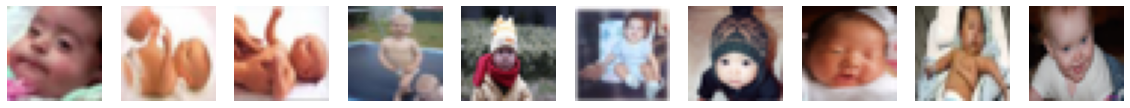

<Figure size 432x288 with 0 Axes>

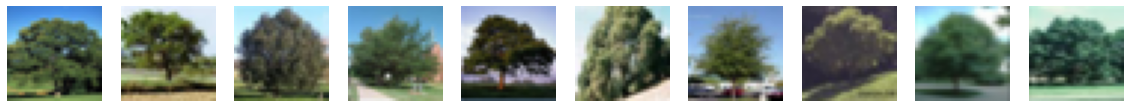

<Figure size 432x288 with 0 Axes>

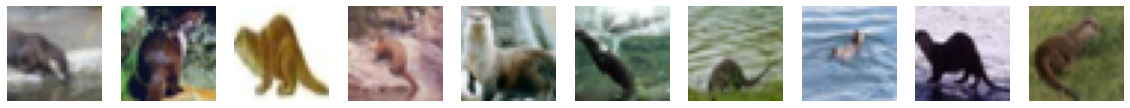

<Figure size 432x288 with 0 Axes>

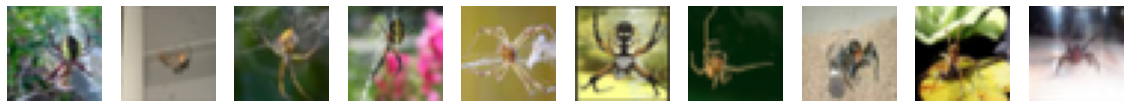

<Figure size 432x288 with 0 Axes>

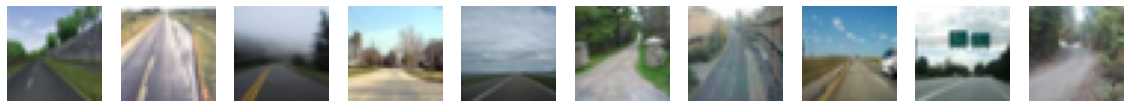

In [13]:
n_images = 10
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 4))

    label = stta_order[:15][j]
    plot_idxs = np.where(harmed_class_labels == label)[0]
    for i in range(n_images):
        ax = axs[i%10]
        img = np.transpose(harmed_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_cifar100(img)
        ax.imshow((img*255).astype(np.uint8))
        ax.axis('off')

In [14]:
helped_class_names, stta_order[-15:]

(['man',
  'lobster',
  'cockroach',
  'forest',
  'ray',
  'castle',
  'television',
  'boy',
  'wolf',
  'camel',
  'crocodile',
  'shark',
  'flatfish',
  'bear',
  'mouse'],
 [46.0,
  45.0,
  24.0,
  33.0,
  67.0,
  17.0,
  87.0,
  11.0,
  97.0,
  15.0,
  27.0,
  73.0,
  32.0,
  3.0,
  50.0])

In [15]:
harmed_class_names, stta_order[:15]

(['skunk',
  'turtle',
  'couch',
  'fox',
  'sweet_pepper',
  'baby',
  'oak_tree',
  'otter',
  'spider',
  'road',
  'computer_keyboard',
  'elephant',
  'willow_tree',
  'clock',
  'aquarium_fish'],
 [75.0,
  93.0,
  25.0,
  34.0,
  83.0,
  2.0,
  52.0,
  55.0,
  79.0,
  68.0,
  39.0,
  31.0,
  96.0,
  22.0,
  1.0])

# Looking at what happens to augmentation predictions when label is corrupted

In [16]:
# what labels are refrigerator, breastplate, and shower cap mistaken for? 
# what lables are the helped classes mistaken for?
corruptions_list = list(corruptions)
corrections_list = list(corrections)
idx_list = corruptions_list
outputs_ta = outputs[:,idx_list,:] 
orig_preds_ta = orig_preds[idx_list,:]
labels_ta = labels[idx_list]

In [22]:
# Indices with respect to corruptions_list
class_opt = stta_order[:15][5]
#class_opt = stta_order[-15:][-5]

class_name = flowers_classes[int(class_opt)]
class_idxs = np.where(np.array(labels[idx_list]) == class_opt)[0]
# Indices with respect to full dataset
class_idxs = [idx_list[i] for i in class_idxs]

outputs_ta = outputs[:,class_idxs,:]
orig_preds_ta = orig_preds[class_idxs,:]
print([flowers_classes[int(i)] for i in np.argmax(np.mean(outputs_ta, axis=0), axis=1)])
print([flowers_classes[int(class_opt)]])
print([flowers_classes[int(i)] for i in np.argmax(orig_preds_ta, axis=1)])

['man', 'boy', 'aquarium_fish', 'man']
['baby']
['baby', 'baby', 'baby', 'baby']


In [48]:
%load_ext autoreload
%autoreload 2
from utils.aug_utils import invert_aug_list
aug_list = np.load('../' + 'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_list.npy')
aug_order = np.load('../' +'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Heat map of logit outputs for 10 most likely classes (true class=oak_tree, \n for each test time augmentation')

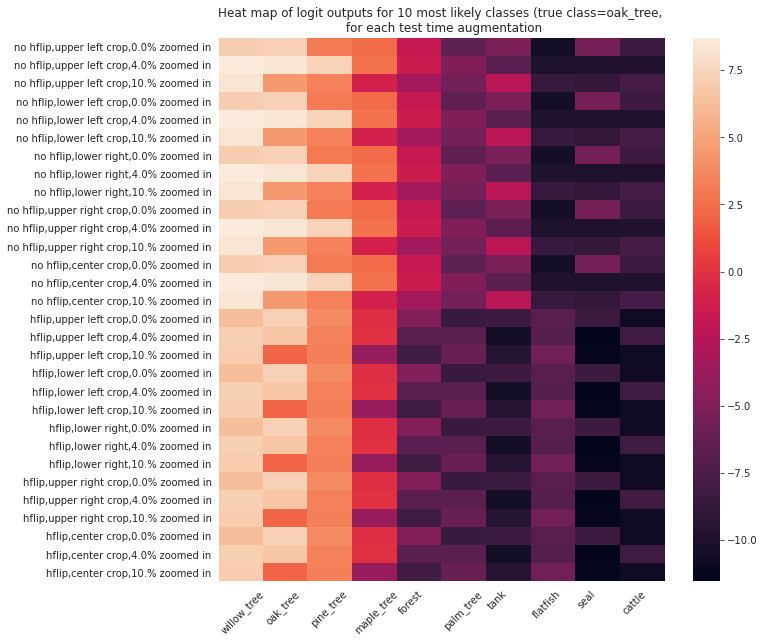

In [49]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style('white')
img_idx = 3
img_output = outputs_ta[:,img_idx,:]
most_likely_classes = np.argsort(-1*np.mean(img_output, axis=0))[:10]
img_output = img_output[:,most_likely_classes]
ax = sns.heatmap(img_output)
plt.xticks(list(range(10)), [flowers_classes[int(i)] for i in most_likely_classes],  
           rotation = 45, ha="left")
ax.set_yticklabels(aug_names, ha='right')
plt.yticks(rotation=0)
plt.title("Heat map of logit outputs for 10 most likely classes (true class=" + \
          class_name.split(',')[0] + ", \n for each test time augmentation")

# Is the benefit of TTA correlated with the difficulty of the class?

In [53]:
# grouped bar plot across classes 
from scipy.stats import pearsonr
orig_class_acc = np.zeros(n_classes)
for i in range(n_classes):
    class_idxs = np.where(labels == i)[0]
    n_correct = len(set(class_idxs).intersection(orig_correct_idxs))
    orig_class_acc[i] = n_correct/len(class_idxs)

stta_class_acc = np.zeros(n_classes)
for i in range(n_classes):
    class_idxs = np.where(labels == i)[0]
    n_correct = len(set(class_idxs).intersection(stta_correct_idxs))
    stta_class_acc[i] = n_correct/len(class_idxs)

class_stta_improvement_list = np.zeros(n_classes)
for i in range(n_classes):
    if i not in net_stta_improvement:
        class_stta_improvement_list[i] = 0
    else:
        class_stta_improvement_list[i] = net_stta_improvement[i]

print(pearsonr(orig_class_acc, class_stta_improvement_list))
# calculate each class's accuracy from orig_preds and labels
# create accuracy map 
# iterate over net_stta_improvement and class_acc 

(-0.24675325245757765, 0.013327120282728686)


Text(0.5, 1.0, 'Effect of Standard TTA on CIFAR-100')

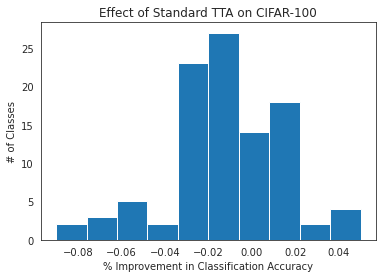

In [57]:
plt.hist(orig_class_acc - stta_class_acc)
plt.xlabel("% Improvement in Classification Accuracy")
plt.ylabel("# of Classes")
plt.title("Effect of Standard TTA on CIFAR-100")

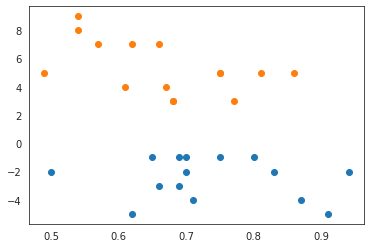

In [52]:
#plt.scatter(class_acc, class_stta_improvement_list)
plt.scatter(class_acc[np.array(stta_order[:15]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[:15]).astype(int)])
plt.scatter(class_acc[np.array(stta_order[-15:]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[-15:]).astype(int)])

In [83]:
class_acc[np.array(stta_order[:15]).astype(int)]

array([0.89814815, 0.65454545, 0.7761194 , 0.96      , 0.88888889,
       0.93939394, 0.87356322, 0.88235294, 1.        , 0.98181818,
       0.94117647, 1.        , 1.        , 0.9       , 0.97      ])

# Train w model on resnet-18 outputs to see if it improves upon STTA

In [84]:
# Write new w model 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
class ImageWAugPred(nn.Module):
    
    def __init__(self, n_augs, n_classes):
        super().__init__()
        n_full = 30
#         self.fc3 = nn.Linear(n_augs*n_classes, n_augs)
        self.fc3 = nn.Linear(n_augs*n_classes, n_full)
#         self.fc3 = nn.Linear(n_augs*n_classes, n_augs)
        nn.init.xavier_uniform(self.fc3.weight)

#         self.dropout1 = nn.Dropout2d(0.5)
        self.fc4 = nn.Linear(n_full, n_augs)
        nn.init.xavier_uniform(self.fc4.weight)

        self.sm = nn.Softmax(dim=1)
#         self.orig_idx = 15
        
#         self.coeffs = nn.Parameter(torch.randn((n_augs), requires_grad=True, dtype=torch.float))
#         self.coeffs.data.fill_(1.0/n_augs)
        
    def forward(self, x):
        # x is a [B, A, H, W] matrix 
        w = self.fc3(torch.flatten(x, 1))
        w = F.relu(w)
        w = self.fc4(w)
        w = self.sm(w)
        #w = (w.T/torch.sum(w.T, axis=0)).T
        permuted_x = x.permute(2, 0, 1)
        aug_preds = permuted_x * w
        aug_pred = aug_preds.mean(axis=2)
        return w, aug_pred.permute(1, 0)
#         aug_preds = self.coeffs * x.permute(0, 2, 1)
#         return aug_preds.mean(axis = 2)
    
    
    
    def get_w(self, x):
        w = self.fc3(torch.flatten(x, 1))
#         w = F.relu(w)
#         w = self.dropout1(w)
#         w = self.fc4(w)
#         w = self.sm(w)
        
        #w = self.fc3(x[:,self.orig_idx,:])
        w = self.sm(w)
        
        return  w
class StandardTTA(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # x is a [B, A, H, W] matrix 
        return x.mean(axis=1)
    
class AugPredsDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return self.samples.shape[1]

    def __getitem__(self, idx):
        return self.samples[:,idx,:], self.labels[idx]
# split augmentation predictions into train and test set 
# train model

In [37]:
train_idxs, test_idxs = train_test_split(range(outputs.shape[1]), test_size=.5)
train_outputs, train_labels = outputs[:,train_idxs,:], labels[train_idxs]
test_outputs, test_labels = outputs[:,test_idxs,:], labels[test_idxs]
train_outputs_ds = AugPredsDataset(train_outputs, train_labels)
test_outputs_ds = AugPredsDataset(test_outputs, test_labels)
train_dl = DataLoader(train_outputs_ds, batch_size=50, shuffle=True)
test_dl = DataLoader(test_outputs_ds, batch_size=50, shuffle=True)


In [ ]:
import torch
from tqdm.notebook import tqdm
n_augs = 30
n_classes = 1000
agg_model = ImageWAugPred(n_augs, n_classes)
agg_model.cuda('cuda:0')
agg_model.train()
criterion = torch.nn.CrossEntropyLoss()
mse_loss = nn.MSELoss(reduction='mean')
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(agg_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)
from utils.imagenet_utils import accuracy

losses = []
acc1s = []
epochs = 1000
lambda1 = .01
for epoch in tqdm(range(epochs)):
    epoch_loss = []
    for examples, target in train_dl:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        w, output = agg_model(examples.float())
        
        stta_w = np.zeros(w.shape)
        stta_w[:,:] = 1/n_augs
        stta_w = torch.Tensor(stta_w).cuda()
        
        loss = criterion(output, target.long())
        #loss += lambda1*mse_loss(w, stta_w)
        all_params = torch.cat([x.view(-1) for x in agg_model.parameters()])
        acc1  = accuracy(output, target.long(), topk=(1,))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        acc1s.append(acc1[0].item())
    losses.append(np.mean(epoch_loss))

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


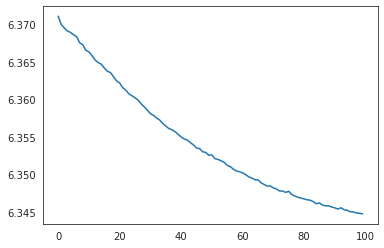

In [325]:
plt.plot(losses)

In [326]:
acc1s = []
agg_model.eval()
acc1_val = 0 
for examples, target in test_dl:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)
    w, output = agg_model(examples.float())
    acc1  = accuracy(output, target.long(), topk=(1,))
    acc1s.append(acc1[0].item())
    acc1_val += acc1[0].item()*len(examples)/(len(examples)*len(test_dl))
print(acc1_val)

75.80800000000006


In [310]:
ws = []
agg_model.eval()
for examples, target in test_dl:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)
    w = agg_model.get_w(examples.float())
    ws.append(w)
ws = [w.detach().cpu().numpy() for w in ws]
print(ws)

[array([[7.0675293e-07, 1.2321350e-06, 3.8109652e-06, ..., 4.1108884e-05,
        5.1647410e-02, 2.1068751e-09],
       [6.4898080e-24, 2.0758995e-11, 3.5772459e-12, ..., 1.5674814e-05,
        3.4548902e-14, 2.8079467e-06],
       [4.3447704e-15, 1.9331183e-06, 4.8919317e-11, ..., 9.2760986e-01,
        9.4558645e-19, 1.1099327e-15],
       ...,
       [3.2189592e-21, 8.7537957e-17, 6.9625325e-12, ..., 3.6469797e-07,
        5.8029068e-16, 1.7606860e-08],
       [3.0176549e-11, 3.9739698e-19, 1.6626095e-10, ..., 2.3722741e-11,
        1.1347547e-11, 1.8086369e-09],
       [5.7444788e-07, 2.6510045e-06, 1.1848368e-07, ..., 1.3715355e-11,
        6.4174885e-01, 7.7270266e-07]], dtype=float32), array([[9.8376629e-10, 8.3475190e-15, 4.3543892e-08, ..., 9.9227554e-01,
        1.5581658e-03, 2.5350876e-11],
       [2.0955631e-25, 2.8805869e-19, 8.9766837e-16, ..., 1.5648431e-04,
        3.0503330e-23, 2.2647359e-12],
       [8.5034153e-06, 2.5600502e-13, 3.8585799e-06, ..., 7.0809379e-02,
 

In [311]:
from scipy.special import softmax
softmaxed_ws = [softmax(ws[i], axis=1) for i in range(len(ws))]
softmaxed_ws[2]

array([[0.03159469, 0.03159469, 0.03159469, ..., 0.08243115, 0.03159469,
        0.03159469],
       [0.03152755, 0.03152755, 0.03152755, ..., 0.03152755, 0.03152755,
        0.03152755],
       [0.03173015, 0.03173015, 0.03173015, ..., 0.03642823, 0.03173015,
        0.03173015],
       ...,
       [0.03180067, 0.03180067, 0.03180067, ..., 0.03180067, 0.03184892,
        0.03180067],
       [0.03153205, 0.03153205, 0.03153205, ..., 0.08548748, 0.03153205,
        0.03153205],
       [0.03152755, 0.03152755, 0.03152755, ..., 0.08570077, 0.03152755,
        0.03152755]], dtype=float32)

In [312]:
softmax(ws[0][9])

array([0.03152878, 0.03152858, 0.03152858, 0.03152858, 0.03152858,
       0.03152858, 0.03152858, 0.03152858, 0.03153589, 0.03152858,
       0.03152858, 0.03152858, 0.03152859, 0.03152858, 0.03152858,
       0.03152858, 0.03152858, 0.03152858, 0.03152858, 0.03152858,
       0.03152858, 0.03152858, 0.08565265, 0.03153374, 0.03152858,
       0.03152858, 0.03152858, 0.03153459, 0.03152858, 0.03152858],
      dtype=float32)

Text(0.5, 1.0, 'Augmentation weights for different images')

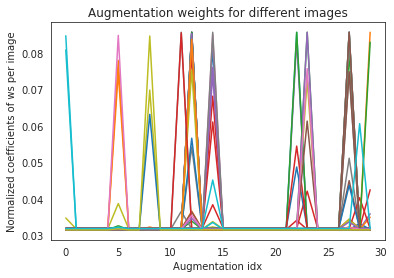

In [313]:
plt.plot(softmaxed_ws[0].T)
plt.ylabel("Normalized coefficients of ws per image")
plt.xlabel("Augmentation idx")
plt.title("Augmentation weights for different images")


In [314]:
acc1_val = 0
stta_model = StandardTTA()
stta_model.eval()
for examples, target in test_dl:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)
    output = stta_model(examples.float())
    acc1  = accuracy(output, target.long(), topk=(1,))
    acc1_val += acc1[0].item()*len(examples)/(len(examples)*len(test_dl))
print(acc1_val)

76.65200000000009


In [74]:
agg_model.fc3.weight

Parameter containing:
tensor([[0.0649, 0.0605, 0.0606,  ..., 0.1457, 0.0616, 0.2831],
        [0.0891, 0.0500, 0.1343,  ..., 0.2566, 0.0544, 0.1924],
        [0.3176, 0.0459, 0.3494,  ..., 0.0872, 0.1329, 0.0109],
        ...,
        [0.0376, 0.0175, 0.0815,  ..., 0.1724, 0.0392, 0.6550],
        [0.0954, 0.4003, 0.4031,  ..., 0.4975, 0.0416, 0.2911],
        [0.3534, 0.4981, 0.1664,  ..., 0.7680, 0.7060, 0.1049]],
       device='cuda:0', requires_grad=True)

In [99]:
# First train the model to match the standard test-time augmentation predictions; 
# aka learn to output 1/n for each augmentation
# THEN train on the original predictions to improve upon this

tensor([[-2.9510e+00, -1.9315e+00, -4.1235e+00,  ...,  9.0053e-01,
         -4.0537e-01, -1.2757e-01],
        [-2.9716e+00,  1.4964e+00, -3.4361e+01,  ...,  1.6173e+02,
          1.0489e+02, -2.5154e+01],
        [-7.8885e+00, -2.1655e+00, -5.1399e+00,  ..., -1.8791e+00,
          2.5302e-02,  1.5514e+00],
        ...,
        [-6.9392e+00, -2.8483e+00,  4.8328e+00,  ..., -1.1060e+01,
          4.9964e+00,  5.6134e+00],
        [ 6.2904e+00,  1.8414e+00, -8.1045e+00,  ...,  9.9433e+00,
          1.6462e+01,  1.2102e+01],
        [-3.2555e+00, -5.7166e+00, -7.7127e+00,  ...,  3.8872e+00,
          3.7308e+00,  1.3366e+00]], device='cuda:0',
       grad_fn=<PermuteBackward>)

In [ ]:
# Right now: 69.4% predicting from the original prediction, 69.12 predicting from the set 
# of predictions (30000 feature long vector)
# look at what w's are learned
# look at which classes are helped
# move all this to a different file so its easier to debug

# Implement simple val set rule

In [ ]:
# apply standard tta to val set 
# see which predicted classes have the highest chance of introducing a test-time 
# augmentation error. this is important because we don't have access to the true class
# for each example, keep track of original pred, true pred, stta pred